In [1]:
#!pip install yfinance
#!pip install vectorbt
#!pip install mplfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import mplfinance as mpf
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Backtest
---
Backtest é um processo onde você aplica as premissas do seu modelo em uma simulação com dados históricos para testar seu desempenho

Tabela de valores críticos para Pearson

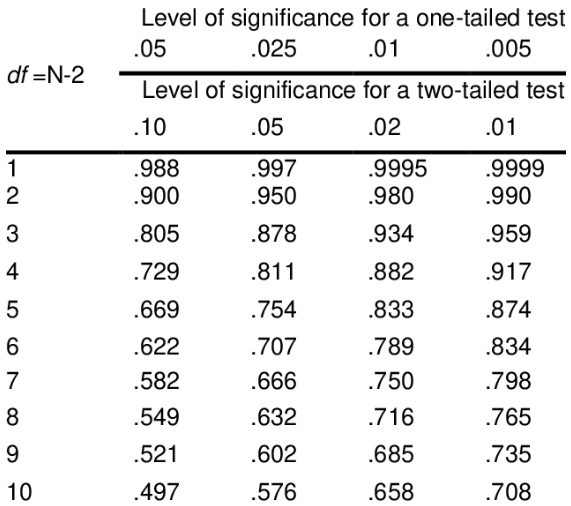

Parâmetros

In [3]:
tickers = ['ITUB4.SA', 'PETR4.SA','MGLU3.SA', 'BTC-USD']

Vamos definir os parâmetros da estratégia

- Long Only: somente entrar comprado
- Entrar comprado quando a autocorr for maior que 0.878
- Sair da compra quando a autocorr se tornar maior que 0.878 

Entretanto somente isso não é suficente!

- Autocorrelação positiva pode nos trazer uma tendência de alta ou de baixa!
- Vamos trazer outra ferramenta além dos parâmetros de autocorrelação para entrada.

In [5]:
#Parâmetro da janela de autocorrelação NÃO CONFUNDIR COM LAG!

janela_rolling = 10

#Lista para appendar e também calcular a autocorrelação
lista_dados = []

for i in tickers:
    ticker_ohlc = yf.download(i, start='2012-07-01', end='2022-06-30')
    ticker_ohlc['autocorr'] = ticker_ohlc['Close'].rolling(janela_rolling).apply(lambda x: x.autocorr(), raw = False)
    lista_dados.append(ticker_ohlc)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Criar uma lógica de benchmark

buy_and_hold = []

for i in range(0, len(tickers)):
    entradas = lista_dados[i]['Close'].iloc[0]
    saidas = lista_dados[i]['Close'].iloc[-1]
    retornos = (saidas/entradas)-1
    buy_and_hold.append(retornos)

bh = pd.DataFrame(buy_and_hold, columns=['Buy&Hold'])
bh

Buy&Hold
0   0.786016
1   0.529412
2   7.230538
3  42.260999

In [9]:
#Gatilhos da estratégia

#lista de sinais
lista_entradas_autocorr = []
lista_saidas_autocorr = []

for i in range(0, len(tickers)):
    entradas = (lista_dados[i]['autocorr'] > 0.8).vbt.signals.AND(lista_dados[i]['Close'] > lista_dados[i]['Close'].shift(janela_rolling))
    saidas = (lista_dados[i]['autocorr'] > 0.8).vbt.signals.AND(lista_dados[i]['Close'] < lista_dados[i]['Close'].shift(janela_rolling))

    lista_entradas_autocorr.append(entradas)
    lista_saidas_autocorr.append(saidas)

In [11]:
#Criando o backtest

#longonly = só comprado
#shortonly = só vendido
#both = comprado e vendido

lista_resultados_autocorr = []

for i in range(0, len(tickers)):
    estrategia_autocorr = vbt.Portfolio.from_signals(lista_dados[i].Close, lista_entradas_autocorr[i], lista_saidas_autocorr[i], direction='longonly', price = lista_dados[i].Open.vbt.bshift(1))
    lista_resultados_autocorr.append(estrategia_autocorr)


In [26]:
#Criar um log para relatório

lista_positions_autocorr = []

for i in range(0, len(tickers)):
  positions = vbt.Portfolio.from_signals(lista_dados[i].Close, lista_entradas_autocorr[i], lista_saidas_autocorr[i], direction='longonly', price=lista_dados[i].Open.vbt.bshift(1)).positions
  lista_positions_autocorr.append(positions)


In [15]:
#Lista de Retornos

lista_retornos_autocorr = []

for i in range(0, len(tickers)):
    total_return_autocorr = (tickers[i], lista_resultados_autocorr[i].total_return())
    lista_retornos_autocorr.append(total_return_autocorr)

overview = pd.DataFrame(lista_retornos_autocorr,columns=['Ativo', 'Retorno'])
overview= pd.merge(overview, bh, how='inner', left_index=True, right_index=True)
overview.index = overview.Ativo
overview.drop(['Ativo'], axis=1, inplace=True)
overview

Retorno   Buy&Hold
Ativo                          
ITUB4.SA    0.753999   0.786016
PETR4.SA    4.094150   0.529412
MGLU3.SA   82.220130   7.230538
BTC-USD   118.544009  42.260999

In [16]:
fig = ff.create_table(overview, height_constant=60, index=True)
fig.layout.margin.update({'t':75, 'l':50})
fig.layout.update({'height':300,'width':500})
fig.show()

## Análise de consistência

In [22]:
lista_resultados_autocorr[0].plot(subplots=['value'],\
                                width=600, height=400, title='Resultado ITUB4').show()

In [23]:
lista_resultados_autocorr[1].plot(subplots=['value'],\
                                width=600, height=400, title='Resultado PETR4').show()

In [24]:
lista_resultados_autocorr[2].plot(subplots=['value'],\
                                width=600, height=400, title='Resultado MGLU3').show()

In [25]:
lista_resultados_autocorr[3].plot(subplots=['value'],\
                                width=600, height=400, title='Resultado BTC-USD').show()

## Análise das Posições

In [27]:
posicao_1 = lista_positions_autocorr[0].records_readable
posicao_2 = lista_positions_autocorr[1].records_readable
posicao_3 = lista_positions_autocorr[2].records_readable
posicao_4 = lista_positions_autocorr[3].records_readable

In [45]:
posicao_4

Position Id  Column      Size Entry Timestamp  Avg Entry Price  \
0             0       0  0.255303      2014-10-13       391.691986   
1             1       0  0.242484      2014-11-10       365.856995   
2             2       0  0.344684      2015-01-24       247.352005   
3             3       0  0.325049      2015-06-16       250.822998   
4             4       0  0.305150      2015-07-27       293.632996   
5             5       0  0.357795      2015-09-07       239.845993   
6             6       0  0.322311      2015-10-15       254.296005   
7             7       0  0.306773      2016-04-08       420.811005   
8             8       0  0.336830      2016-09-05       606.505981   
9             9       0  0.338780      2017-02-19      1048.689941   
10           10       0  0.324162      2017-04-02      1102.949951   
11           11       0  0.227052      2017-08-07      3370.219971   
12           12       0  0.165608      2017-09-30      4341.049805   
13           13       0  0.122331      2017-11-19      8039.069824   
14           14       0  0.153921      2018-02-17     11123.400391   
15           15       0  0.172623      2018-04-15      8337.570312   
16           16       0  0.214350      2018-07-07      6857.799805   
17           17       0  0.226367      2018-08-29      7043.759766   
18           18       0  0.217247      2018-10-24      6484.649902   
19           19       0  0.293182      2018-12-20      4133.703613   
20           20       0  0.253626      2019-02-20      4000.256836   
21           21       0  0.222455      2019-08-03     10821.632812   
22           22       0  0.217013      2019-09-05     10578.198242   
23           23       0  0.234926      2019-11-01      9259.783203   
24           24       0  0.233221      2020-01-08      8082.295898   
25           25       0  0.275596      2020-04-08      7337.966309   
26           26       0  0.254086      2020-07-23      9585.514648   
27           27       0  0.205035      2021-03-10     55963.179688   
28           28       0  0.179306      2021-04-01     59098.878906   
29           29       0  0.259065      2021-07-26     37276.035156   
30           30       0  0.307803      2021-12-26     50802.609375   
31           31       0  0.332437      2022-01-31     38481.765625   
32           32       0  0.279432      2022-03-25     44349.859375   

    Entry Fees Exit Timestamp  Avg Exit Price  Exit Fees          PnL  \
0          0.0     2014-10-25      347.487000        0.0   -11.285650   
1          0.0     2014-11-21      351.604004        0.0    -3.456118   
2          0.0     2015-04-11      236.535004        0.0    -3.728445   
3          0.0     2015-07-21      275.657013        0.0     8.072274   
4          0.0     2015-08-03      281.225006        0.0    -3.786296   
5          0.0     2015-09-16      229.076004        0.0    -3.853451   
6          0.0     2016-03-05      400.524994        0.0    47.131162   
7          0.0     2016-06-25      665.931030        0.0    75.196218   
8          0.0     2017-02-18     1054.760010        0.0   150.985615   
9          0.0     2017-03-20     1055.359985        0.0     2.259678   
10         0.0     2017-07-13     2360.590088        0.0   407.679740   
11         0.0     2017-09-14     3166.300049        0.0   -46.300398   
12         0.0     2017-11-12     5938.250000        0.0   264.509775   
13         0.0     2017-12-24    13995.900391        0.0   728.702560   
14         0.0     2018-03-09     9350.589844        0.0  -272.873052   
15         0.0     2018-05-12     8515.490234        0.0    30.713011   
16         0.0     2018-08-03     7438.669922        0.0   124.509275   
17         0.0     2018-09-08     6223.379883        0.0  -185.707065   
18         0.0     2018-11-16     5578.580078        0.0  -196.840685   
19         0.0     2019-01-31     3460.547119        0.0  -197.357474   
20         0.0     2019-07-27     9491.626953        0.0  1392.756344   
21         0.0   

In [32]:
posicao_1.groupby(['Direction']).sum()['PnL']

Direction
Long    75.399862
Name: PnL, dtype: float64

In [33]:
posicao_2.groupby(['Direction']).sum()['PnL']

Direction
Long    409.414996
Name: PnL, dtype: float64

In [34]:
posicao_3.groupby(['Direction']).sum()['PnL']

Direction
Long    8222.013046
Name: PnL, dtype: float64

In [35]:
posicao_4.groupby(['Direction']).sum()['PnL']

Direction
Long    11854.400886
Name: PnL, dtype: float64

## Análise de Retornos

In [42]:
fig = make_subplots(rows=2,
                     cols=2,
                     row_heights=[5,5],
                     column_widths=[3,3],
                     subplot_titles=(tickers[0],tickers[1],tickers[2],tickers[3]),
                     shared_xaxes=False)
'''
fig.add_trace(go.Histogram(x=posicao_1['Return']),row=1,col=1)
fig.add_trace(go.Histogram(x=posicao_2['Return']),row=1,col=2)
fig.add_trace(go.Histogram(x=posicao_3['Return']),row=2,col=1)
fig.add_trace(go.Histogram(x=posicao_4['Return']),row=2,col=2)
'''
fig.add_trace(go.Histogram(x=posicao_1['Return'], nbinsx=20),row=1,col=1)
fig.add_trace(go.Histogram(x=posicao_2['Return'], nbinsx=20),row=1,col=2)
fig.add_trace(go.Histogram(x=posicao_3['Return'], nbinsx=20),row=2,col=1)
fig.add_trace(go.Histogram(x=posicao_4['Return'], nbinsx=20),row=2,col=2)


fig.update_layout(title_text='<b>Avaliação de Retornos<b>',
                    template='simple_white',
                    showlegend=False,
                    height=500,
                    width=900)
fig.show()

## Boxplot Retornos

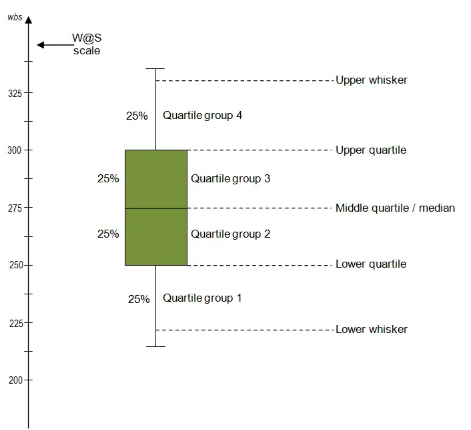

In [44]:
fig = go.Figure()

fig.add_trace(go.Box(y=posicao_1['Return'], boxmean='sd', name=tickers[0]))
fig.add_trace(go.Box(y=posicao_2['Return'], boxmean='sd', name=tickers[1]))
fig.add_trace(go.Box(y=posicao_3['Return'], boxmean='sd', name=tickers[2]))
fig.add_trace(go.Box(y=posicao_4['Return'], boxmean='sd', name=tickers[3]))

fig.update_layout(title_text='<b>Boxplot Retornos<b>', template='simple_white', height=500, width=900)
fig.show()

## Análise do PnL

In [47]:
y=[posicao_1['PnL'].sum(), posicao_2['PnL'].sum(), posicao_3['PnL'].sum(), posicao_4['PnL'].sum()]

fig = go.Figure()
fig.add_trace(go.Bar(x=tickers, y=y, text=y, textposition='outside', textfont_color='black'))
fig.update_layout(title_text='<b>PnL Analysis', template='simple_white', height=500, width=900)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

## Drawdown

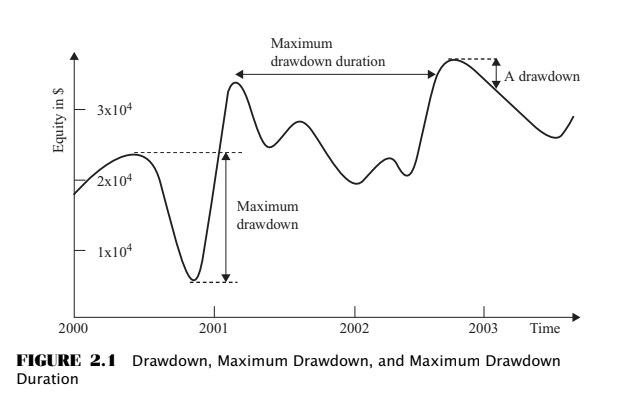

Chan, Ernest P.
Quantitative trading: how to build your own algorithmic trading business / Ernest P. Chan. 2009

In [48]:
y=[lista_resultados_autocorr[0].max_drawdown(),
   lista_resultados_autocorr[1].max_drawdown(), 
   lista_resultados_autocorr[2].max_drawdown(), 
   lista_resultados_autocorr[3].max_drawdown()]

fig = go.Figure()
fig.add_trace(go.Bar(x=tickers, y=y,
                     text=y, textposition='outside'))
fig.update_layout(title_text='<b>Max Drawdown Analysis<b>',template='simple_white', height=500, width=900)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

### Drawdown duration

In [49]:
lista_resultados_autocorr[0].plot_underwater().show()

In [50]:
lista_resultados_autocorr[1].plot_underwater().show()

In [51]:
lista_resultados_autocorr[2].plot_underwater().show()

In [52]:
lista_resultados_autocorr[3].plot_underwater().show()